<a href="https://colab.research.google.com/github/KacperGrodecki/nieruchomosci-mazowieckie/blob/0.0.4/mazowieckie_colab_DNN_mieszkania.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from sklearn.metrics import confusion_matrix
from sklearn import svm
import pandas as pd
import numpy as np
np.random.seed(7)
from google.colab import drive
import seaborn as sns
drive.mount('/content/drive')
import matplotlib.pyplot as plt
import pandas as pd
#from otoDomScraper import daneDomu
#from random import randrange
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import statistics
from sklearn.cluster import AffinityPropagation
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.decomposition import FastICA
from sklearn import preprocessing
from IPython.display import Javascript
import requests
from collections import OrderedDict
import seaborn as sns

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:
def toNum2(txt):
    if type(txt) is int:
        return txt
    elif (type(txt) is str):
        digs = re.findall(r'\d+', txt)
        if len(digs) == 1:
            return int(digs[0])
        elif len(digs) == 2:
            return 1000 * int(digs[0]) + int(digs[1])
        elif len(digs) == 3:
            return 1000000 * int(digs[0]) + 1000 * int(digs[1]) + int(digs[0])

    #   return int(digs)


def toNum1(txt):
    if type(txt) is str:
        digs = re.findall(r'\d+', txt)
        if len(digs) == 1:
            return int(digs[0])
        elif len(digs) == 2 and (txt[1] != ' '):
            return int(digs[0]) + 0.01 * int(digs[1])
        elif len(digs) == 3:
            return 1000 * int(digs[0]) + int(digs[1]) + 0.001 * int(digs[2])
        elif (type(txt) is str) and (txt[1] == ' '):
            digs = re.findall(r'\d+', txt)
            return 1000 * int(digs[0]) + int(digs[1])
    else:
        return txt


def toNum3(txt):
    if type(txt) == int:
        return txt
    elif type(txt) == float:
      if np.isnan(txt):
        return 0
      else:
        return int(txt)

    return int(re.findall(r'\d+', txt)[0])

def pietra(txt):
    if type(txt) is str:
        if '0' in txt:
            return 0
        if '1' in txt:
            return 1
        elif '2' in txt:
            return 2
        elif '3' in txt:
            return 3
        elif 'parterowy' in txt:
            return 0
    elif type(txt)==float:
      if np.isnan(txt):
        return 0
      else:
        return int(txt)
    elif type(txt)==int:
      return txt
    else:
      return txt

      

def cities(x):
    dist=x.split()[4]
    #city=x.split()[5]
    if dist=='warszawski':
        return x.split()[6]
    elif dist in ['Warszawa','Radom','Płock','Siedlce']:
        return dist
    else:
        try:
            return x.split()[5]
        except:
            return 'unknown'

def region(x):
    if x.split()[4]=='Warszawa':
        try:
            return x.split()[5]
        except:
            return ''
    else:
        return ''

In [11]:
def makeDataFrame(file):
    dfMazowieckie=pd.read_csv(file,index_col=0,names=['dzielnica','powierzchnia','lPokoi','powierzchniaDzialki','rodzajZabudowy','materialBudynku','rokBudowy',
                                                      'stanWykonczenia','okna','rynek','lPieter','cena'])
    concat=dfMazowieckie
    concat['powierzchnia_corr'] = concat['powierzchnia'].apply(lambda x: toNum1(x))
    concat['powierzchniaDzialki_corr'] = concat['powierzchniaDzialki'].apply(lambda x: toNum2(x))
    concat['cena_corr'] = concat['cena'].apply(lambda x: toNum2(x))
    concat['rokBudowy_corr'] = concat['rokBudowy'].apply(lambda x: toNum3(x))
    concat['cena/m'] = concat['cena_corr'] / concat['powierzchnia_corr']
    concat['lPieter_crr'] = concat['lPieter'].apply(lambda x: pietra(x))
    concat = concat[concat['powierzchnia_corr'] > 0]
    concat = concat[concat['cena_corr'] > 0]
    concat['lPokoi'] = concat['lPokoi'].apply(lambda x: toNum3(x))
    concat['districts']=concat['dzielnica'].apply(lambda x: x.split()[4])
    cities_corr=concat['dzielnica'].apply(lambda x: cities(x))
    concat['cities_corr']=cities_corr
    region_corr=concat['dzielnica'].apply(lambda x: region(x))
    concat['region_corr']=region_corr
    concat_dropped = concat.drop(['dzielnica', 'powierzchnia', 'powierzchniaDzialki', 'lPieter', 'cena', 'cena_corr',], axis=1)
    #['rokBudowy_corr'] = concat_dropped['rokBudowy_corr'].replace(to_replace=0, value=1990)
    concat_dropped['rokBudowy_corr'] = concat_dropped['rokBudowy_corr'].astype('int')
    concat_dropped.loc[concat_dropped['rokBudowy_corr']<1900,'rokBudowy_corr']=1980
    concat_dropped.loc[concat_dropped['rokBudowy_corr']>2030,'rokBudowy_corr']=2020
    #concat_dropped = concat_dropped[concat_dropped['rokBudowy_corr'] < 2030]
    concat_dropped = concat_dropped.fillna(0)
    concat_dropped = concat_dropped[concat_dropped['cena/m'] < 20000]
    concat_dropped['cena/m'].hist(bins=200)

    #concat_dropped_dumm = pd.get_dummies(concat_dropped, columns=['rodzajZabudowy', 'materialBudynku', 'stanWykonczenia', 'okna', 'rynek',
    #                                       'cities_corr','districts','region_corr'])
    
    cityData=concat_dropped.cities_corr.apply(lambda x: funCities(x))
    locationCities=locCities(cityData)
    districtsData=concat_dropped.region_corr.apply(lambda x: funDistricts(x))
    locationDistricts=locCities(districtsData)
    countyData=concat_dropped.districts.apply(lambda x: funCounties(x))
    locationCounty=locCounties(countyData)

    concat_dropped_reset=concat_dropped.reset_index().drop(['index'],axis=1)
    locations= pd.concat([locationCities,locationDistricts,locationCounty], axis=1)
    concat_dropped_reset['locationX']=locations.apply(selectLocationX,axis=1)
    concat_dropped_reset['locationY']=locations.apply(selectLocationY,axis=1)
    concat_dropped_reset_drop = concat_dropped_reset.drop(['rokBudowy', 'districts', 'cities_corr', 'region_corr'], axis=1)
    final = pd.get_dummies(concat_dropped_reset_drop, columns=['rodzajZabudowy', 'materialBudynku', 'stanWykonczenia', 'okna', 'rynek'])

    return final

In [15]:
def selectLocationX(x):
 # print(x[17],x[20],x[23])
  if x[2]<min(x[5],x[8]):
    #print('min 17',x[15],x[16])
    return x[0]
  elif x[5]<min(x[2],x[8]):
    #print('min 20 ',x[18],x[19])
    return x[3]
  elif x[8]<min(x[2],x[5]):
    #print('min 23 ',x[21],x[22])
    return x[6]

def selectLocationY(x):
 # print(x[17],x[20],x[23])
  if x[2]<min(x[5],x[8]):
    #print('min 17',x[15],x[16])
    return x[1]
  elif x[5]<min(x[2],x[8]):
    #print('min 20 ',x[18],x[19])
    return x[4]
  elif x[8]<min(x[2],x[5]):
    #print('min 23 ',x[21],x[22])
    return x[7]

In [16]:
def locCities(cityData):
  locationCities=[]
  for data in cityData:
    locationCities.append(data)
  locationCities=pd.DataFrame(np.array(locationCities),columns=['cityX','cityY','cityGeo'])
  return locationCities

def locDistricts(districtsData):
  locationCities=[]
  for data in cityData:
    locationDistricts.append(data)
  locationDistricts=pd.DataFrame(np.array(locationDistricts),columns=['cityX','cityY','cityGeo'])
  return locationDistricts

def locCounties(countyData):
  locationCounty=[]
  for data in countyData:
    locationCounty.append(data)
  locationCounty=pd.DataFrame(np.array(locationCounty),columns=['countyX','countyY','countyGeo'])
  return locationCounty

In [20]:
filename='/content/drive/My Drive/domymazowieckie/dfMieszkania1.csv'
dfCities=pd.read_csv('/content/drive/My Drive/domymazowieckie/dfcities.csv',index_col=0)
dfCounties=pd.read_csv('/content/drive/My Drive/domymazowieckie/dfCounties.csv',index_col=0)
dfVoivodeships=pd.read_csv('/content/drive/My Drive/domymazowieckie/dfVoivodeships.csv',index_col=0)
dfWarsawDistricts=pd.read_csv('/content/drive/My Drive/domymazowieckie/dfWarsawDistricts.csv',index_col=0)

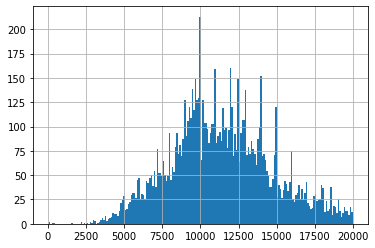

In [62]:
final=makeDataFrame(filename)

In [47]:
final.to_csv('/content/drive/My Drive/domymazowieckie/dfMieszkania_final.csv')

In [56]:
final.head()

,lPokoi,powierzchnia_corr,powierzchniaDzialki_corr,rokBudowy_corr,cena/m,lPieter_crr,locationX,locationY,rodzajZabudowy_0,rodzajZabudowy_apartamentowiec,rodzajZabudowy_blok,rodzajZabudowy_dom wolnostojący,rodzajZabudowy_kamienica,rodzajZabudowy_loft,rodzajZabudowy_plomba,rodzajZabudowy_szeregowiec,materialBudynku_0,materialBudynku_beton,materialBudynku_beton komórkowy,materialBudynku_cegła,materialBudynku_drewno,materialBudynku_inne,materialBudynku_keramzyt,materialBudynku_pustak,materialBudynku_silikat,materialBudynku_wielka płyta,materialBudynku_żelbet,stanWykonczenia_0,stanWykonczenia_do remontu,stanWykonczenia_do wykończenia,stanWykonczenia_do zamieszkania,okna_0,okna_aluminiowe,okna_drewniane,okna_plastikowe,rynek_pierwotny,rynek_wtórny
0,2,59.70,0,2012,16566.164154,6,20.933889,52.288889,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1
1,2,44.44,0,1980,11300.000000,3,NaN,NaN,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
2,4,91.00,0,2021,13571.439560,0,20.957222,52.233333,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
3,2,38.00,0,1977,12763.157895,12,20.933889,52.288889,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1
4,4,74.50,0,2022,8912.751678,3,20.884190,52.195170,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0


In [48]:
df=final.copy()

(array([ 866., 3441., 3231., 1397.,  306.,   46.,   18.,    5.,    0.,
           5.]),
 array([0.1 , 0.19, 0.28, 0.37, 0.46, 0.55, 0.64, 0.73, 0.82, 0.91, 1.  ]),
 <a list of 10 Patch objects>)

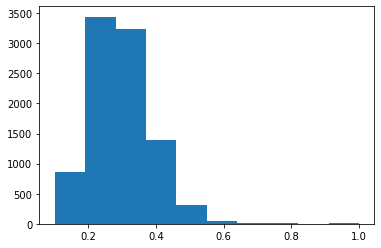

In [49]:
plt.hist(final.loc[:,'lPokoi']/10)

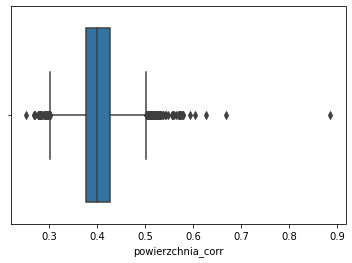

In [50]:
sns.boxplot(x=(np.log(final["powierzchnia_corr"])/10))

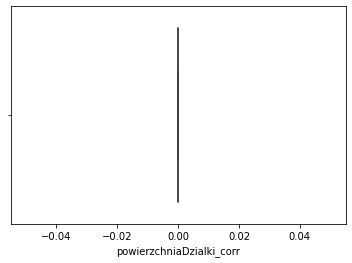

In [51]:
sns.boxplot(x=(np.log(final["powierzchniaDzialki_corr"]+1)/14))

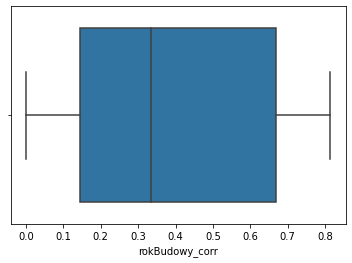

In [52]:
sns.boxplot(x=(np.power(final["rokBudowy_corr"]-1899,4)/3e8))

(array([1340., 2627.,  333.,  309.,  678.,  705.,  523.,  378.,  540.,
        1882.]),
 array([3.33333333e-09, 8.13802113e-02, 1.62760419e-01, 2.44140627e-01,
        3.25520835e-01, 4.06901043e-01, 4.88281251e-01, 5.69661459e-01,
        6.51041667e-01, 7.32421875e-01, 8.13802083e-01]),
 <a list of 10 Patch objects>)

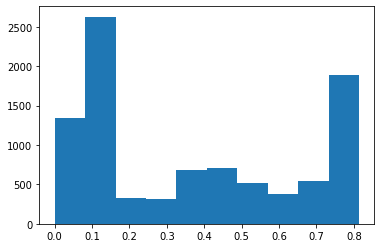

In [53]:
plt.hist(np.power(final["rokBudowy_corr"]-1899,4)/3e8)

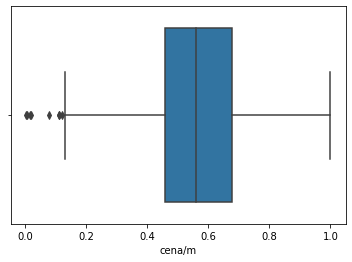

In [54]:
sns.boxplot(x=final["cena/m"]/20000)

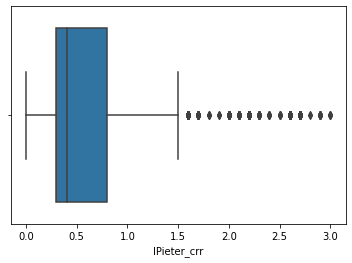

In [63]:
sns.boxplot(x=final["lPieter_crr"]/10)

(array([1641., 4401., 1289., 1247.,  235.,  247.,   32.,   74.,   95.,
          54.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

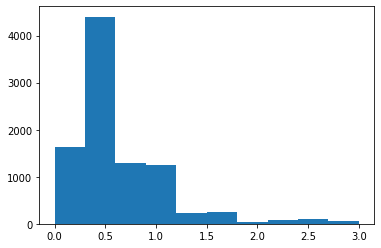

In [36]:
plt.hist(final["lPieter_crr"]/10)

In [38]:
final.head()

,lPokoi,powierzchnia_corr,powierzchniaDzialki_corr,rokBudowy_corr,cena/m,lPieter_crr,locationX,locationY,rodzajZabudowy_0,rodzajZabudowy_apartamentowiec,rodzajZabudowy_blok,rodzajZabudowy_dom wolnostojący,rodzajZabudowy_kamienica,rodzajZabudowy_loft,rodzajZabudowy_plomba,rodzajZabudowy_szeregowiec,materialBudynku_0,materialBudynku_beton,materialBudynku_beton komórkowy,materialBudynku_cegła,materialBudynku_drewno,materialBudynku_inne,materialBudynku_keramzyt,materialBudynku_pustak,materialBudynku_silikat,materialBudynku_wielka płyta,materialBudynku_żelbet,stanWykonczenia_0,stanWykonczenia_do remontu,stanWykonczenia_do wykończenia,stanWykonczenia_do zamieszkania,okna_0,okna_aluminiowe,okna_drewniane,okna_plastikowe,rynek_pierwotny,rynek_wtórny
0,2,59.70,0,2012,16566.164154,6.0,20.933889,52.288889,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1
1,2,44.44,0,1980,11300.000000,3.0,NaN,NaN,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
2,4,91.00,0,2021,13571.439560,0.0,20.957222,52.233333,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
3,2,38.00,0,1977,12763.157895,12.0,20.933889,52.288889,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1
4,4,74.50,0,2022,8912.751678,3.0,20.884190,52.195170,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0


In [ ]:
plt.hist((final["locationX"]-21)/4)

In [ ]:
plt.hist((final["locationY"]-52)/2)

In [ ]:
final.head()

In [ ]:
#min_max_scaler = preprocessing.MinMaxScaler()
#data_scaled = min_max_scaler.fit_transform(final.values)
#df = pd.DataFrame(data_scaled ,columns=final.columns.values)
#df  = df.fillna(0)

NORMALIZACJA!!!!!!!!!!!!!!!!

In [ ]:
df=final.copy()
df['lPokoi']=final.loc[:,'lPokoi']/10
df["powierzchnia_corr"]=np.log(final["powierzchnia_corr"])/10
df["powierzchniaDzialki_corr"]=np.log(final["powierzchniaDzialki_corr"]+1)/14
df["rokBudowy_corr"]=np.power(final["rokBudowy_corr"]-1899,4)/3e8
df["cena/m"]=final["cena/m"]/20000
df["locationX"]=(final["locationX"]-21)/4
df["locationY"]=(final["locationY"]-52)/2
df['lPieter_crr']=final.loc[:,'lPieter_crr']/10

NORMALIZACJA!!!!!!!!!!!!!!!!!

In [ ]:
df  = df.fillna(0)

In [ ]:
df.head()

In [ ]:
#filename_json1='/content/drive/My Drive/domymazowieckie/dfMazowieckieClean.json'
#df.to_json(filename_json1)

In [ ]:
import tensorflow as tf
import tensorflow as tfCore
import math
from IPython.core.magic import register_line_magic
from IPython.display import Javascript


In [ ]:
train_dataset = df.sample(frac=0.8, random_state=0)
test_dataset = df.drop(df.index)

In [ ]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('cena/m')
test_labels = test_features.pop('cena/m')

In [ ]:
train_features,test_features,train_labels,test_labels=train_features.values,test_features.values,train_labels.values,test_labels.values

In [ ]:
train_features = np.array(train_features, dtype=np.float32)
test_features = np.array(test_features, dtype=np.float32)
train_labels = np.array(train_labels, dtype=np.float32)
test_labels = np.array(test_labels, dtype=np.float32)

In [ ]:
train_features.shape

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

In [ ]:
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()


In [ ]:
model= tf.keras.models.Sequential([
                               #    normalizer,
  tf.keras.layers.Dense(18*36, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(8*64, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(8*36, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(4*36, activation='relu'),
  tf.keras.layers.Dense(1, activation='linear'),
])

In [ ]:
model.compile(loss='mean_absolute_error',
              metrics=['mse',"mae",'acc'],optimizer=tf.optimizers.Adam(learning_rate=0.01))#learning_rate=0.01

In [ ]:
with tf.device('/device:GPU:0'):
  history = model.fit(
    train_features, train_labels,
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

In [ ]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.ylim(0.017,0.024)

In [ ]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.ylim(0.090,0.110)

In [ ]:
lPokoi=7
powierzchnia=300
powierzchniaDzialki=1000
rokBudowy=2001
lPieter=1
locationX=21
locationY=52

params_norm=[lPokoi/10,np.log(powierzchnia)/10,np.log(powierzchniaDzialki+1)/14,
             np.power(rokBudowy-1899,4)/3e8,lPieter/10,
             (locationX-21)/4,(locationY-52)/2]

parametry=np.array(params_norm)
zabudowa=np.array([1,0,0,0,0,0,0])
material=np.array([1,0,0,0,0,0,0,0,0])
wykonczenie=np.array([1,0,0,0,0,0])
okna=np.array([1,0,0,0,0])
rynek=np.array([1,0])
x=np.concatenate([parametry,zabudowa,material,wykonczenie,okna,rynek])
x=np.transpose(np.reshape(x,(-1,1)))
print(x)

In [ ]:
cena_m=20000*model.predict(x)[0]
cena=cena_m*powierzchnia
print(cena_m,' ',cena)

In [ ]:
def szybki_podgląd_lokacji(X,Y):
  lPokoi=7
  powierzchnia=300
  powierzchniaDzialki=1000
  rokBudowy=2001
  lPieter=1
  locationX=X
  locationY=Y

  params_norm=[lPokoi/10,np.log(powierzchnia)/10,np.log(powierzchniaDzialki+1)/14,
              np.power(rokBudowy-1899,4)/3e8,lPieter/10,
              (locationX-21)/4,(locationY-52)/2]

  parametry=np.array(params_norm)
  zabudowa=np.array([0,0,0,0,0,0,1])
  material=np.array([0,0,1,0,0,0,0,0,0])
  wykonczenie=np.array([0,0,0,1,0,0])
  okna=np.array([0,0,0,0,1])
  rynek=np.array([0,1])
  x=np.concatenate([parametry,zabudowa,material,wykonczenie,okna,rynek])
  x=np.transpose(np.reshape(x,(-1,1)))
  cena_m=20000*model.predict(x)[0]
  cena=cena_m*powierzchnia
  return cena_m

In [ ]:
price=[]
for i in range(0,25):
  for j in range(0,55):
   price.append(szybki_podgląd_lokacji(i,j))

In [ ]:
price_1=np.array(price).reshape(i+1,j+1)
price_2=np.transpose(price_1)

In [ ]:
plt.imshow(price_1, cmap='hot')
plt.xlim(40,55)
plt.ylim(18,22)
plt.show()

In [ ]:
filename='/content/drive/My Drive/domymazowieckie/dfMazowieckie.h5'
model.save(filename,save_format='tf')

In [ ]:
pip install tensorflowjs

In [ ]:
!tensorflowjs_converter --input_format=keras /content/drive/MyDrive/domymazowieckie/dfMazowieckie.h5 /content/drive/MyDrive/domymazowieckie/jsmodel